# NNS simulation for unfolding using ANN

In [ ]:
import numpy as np
import pandas as pd
import openmc
from scipy.constants import inch
import matplotlib.pyplot as plt

# materials

In [2]:
def stainless_steel_304L():
    material = openmc.Material(name='stainless steel 304L')
    material.add_nuclide('C12', percent=0.0008, percent_type='wo')
    material.add_nuclide('Mn55', percent=0.020000, percent_type='wo')
    material.add_nuclide('P31', percent=0.000450, percent_type='wo')
    material.add_element('S', percent=0.000300, percent_type='wo')
    material.add_element('Si', percent=0.010000, percent_type='wo')
    material.add_element('Cr', percent=0.190000, percent_type='wo')
    material.add_element('Ni', percent=0.095000, percent_type='wo')
    material.add_element('Fe', percent=0.683450, percent_type='wo')
    material.set_density(units='g/cm3', density=0.0012)
    material.set_density(units='g/cm3', density=8)   
    return material
    
def air():
    material = openmc.Material(name='air')
    material.add_nuclide('C12',   percent=0.000124, percent_type='wo')
    material.add_nuclide('N14', percent=0.752316, percent_type='wo')
    material.add_nuclide('N15',  percent=0.002944, percent_type='wo')
    material.add_nuclide('O16',    percent=0.231153, percent_type='wo')
    material.add_nuclide('O17',    percent=0.000094, percent_type='wo')
    material.set_density(units='g/cm3', density=0.001205)
    return material

def polyethylene():
    material = openmc.Material(name='polyethylene')
    material.add_nuclide('H1', percent=0.143686, percent_type='wo')
    material.add_nuclide('H2', percent=0.000033, percent_type='wo')
    material.add_nuclide('C12',percent=0.856276, percent_type='wo')
    material.set_density(units='g/cm3', density=0.935)
    return material

def He3_gas():
    material = openmc.Material(name='he3-proportional gas')
    material.add_nuclide('He3', percent=1, percent_type='wo')
    material.set_density(units='g/cm3', density=1)
    return material
    


# detector universe 

In [3]:
def nns_universe(num_of_shells: int, materials):
    """
    detector universe definition
    """
    detector_clad = 0.001 # 1 mm
    he3_diameter = 0.015
    detector_outer_radii = np.array([he3_diameter/2/inch, 0.015/2/inch+detector_clad/inch, 3, 3.5, 4, 5, 6, 8, 10])*inch*100
    detector_inner_radii = np.array([0, he3_diameter/2/inch, 0.015/2/inch+detector_clad/inch, 3, 3.5, 4, 5, 6, 8])*inch*100
    detector_height = detector_outer_radii
    base_height = -detector_outer_radii/2
    shells = pd.DataFrame({'base_height': base_height,
                       'height': detector_height,
                       'inner_radii': detector_inner_radii,
                       'outer_radii': detector_outer_radii})
    # detector universe
    detector = openmc.Universe()

    # the helium gas
    shell_num = 0
    gas = openmc.Cell(name='he gas')
    gas.region = -openmc.ZCylinder(r=shells['outer_radii'][shell_num]) \
    & -openmc.ZPlane(z0=shells['base_height'][shell_num]+shells['height'][shell_num]) & +openmc.ZPlane(z0=shells['base_height'][shell_num])
    gas.fill = materials[0]
    detector.add_cell(gas)

    # helium clad
    shell_num = shell_num + 1
    previous_reigon = -openmc.ZCylinder(r=shells['outer_radii'][shell_num-1]) \
    & -openmc.ZPlane(z0=shells['base_height'][shell_num-1]+shells['height'][shell_num-1]) & +openmc.ZPlane(z0=shells['base_height'][shell_num-1])
    clad = openmc.Cell(name='detector clad')
    clad.region = -openmc.ZCylinder(r=shells['outer_radii'][shell_num]) \
    & -openmc.ZPlane(z0=shells['base_height'][shell_num]+shells['height'][shell_num]) \
    & +openmc.ZPlane(z0=shells['base_height'][shell_num])\
    & ~previous_reigon
    clad.fill = materials[1]
    detector.add_cell(clad)

    for i in range(2, 2+num_of_shells):
        shell_num = shell_num + 1
        previous_reigon = -openmc.ZCylinder(r=shells['outer_radii'][shell_num-1]) \
        & -openmc.ZPlane(z0=shells['base_height'][shell_num-1]+shells['height'][shell_num-1]) & +openmc.ZPlane(z0=shells['base_height'][shell_num-1])
        shell = openmc.Cell(name=f'NNS shell {i-1}')
        shell.region = -openmc.ZCylinder(r=shells['outer_radii'][shell_num]) \
        & -openmc.ZPlane(z0=shells['base_height'][shell_num]+shells['height'][shell_num]) \
        & +openmc.ZPlane(z0=shells['base_height'][shell_num])\
        & ~previous_reigon
        shell.fill = materials[2]
        detector.add_cell(shell)
    
    air = openmc.Cell(name='air over nns')
    previous_reigon = -openmc.ZCylinder(r=shells['outer_radii'][shell_num]) \
    & -openmc.ZPlane(z0=shells['base_height'][shell_num]+shells['height'][shell_num]) & +openmc.ZPlane(z0=shells['base_height'][shell_num])
    air.region = -openmc.Sphere(r=100, boundary_type='vacuum') & ~previous_reigon
    air.fill = materials[3]   
    detector.add_cell(air)

    gas_id = gas.id
    return detector, shells, gas_id

In [4]:
def nns_fixed_source(num_of_shells, energy_distribution=None):

    materials = openmc.Materials([ He3_gas(), stainless_steel_304L(), polyethylene(), air()])
    openmc.Materials.cross_sections = '/home/achiyaam/Programs/openmc/cross_section/endfb-viii.0-hdf5/cross_sections.xml'
    root_universe = openmc.Universe()

    nns_detector_universe, shells_data, gas_id = nns_universe(num_of_shells, materials)

    nns = openmc.Cell(name='nns')
    nns.region =  -openmc.ZCylinder(r=shells_data['outer_radii'][num_of_shells+1]) \
    & -openmc.ZPlane(z0=shells_data['base_height'][num_of_shells+1]+shells_data['height'][num_of_shells+1]) & +openmc.ZPlane(z0=shells_data['base_height'][num_of_shells+1])
    nns.fill= nns_detector_universe
    root_universe.add_cell(nns)
    
    air_cell = openmc.Cell(name='air around the system')
    air_cell.region = -openmc.Sphere(r=100, boundary_type='vacuum') & ~nns.region
    air_cell.fill = materials[3]
    root_universe.add_cell(air_cell)
    
    geometry = openmc.Geometry(root_universe)
    
    source = openmc.IndependentSource()
    source.space = openmc.stats.Point((30, 0, 0))
    source.angle = openmc.stats.Isotropic()
    source.energy = openmc.stats.Discrete(x=energy_distribution.energy, p=energy_distribution.strength)
    source.particle = 'neutron'
    
    settings = openmc.Settings()
    settings.run_mode = 'fixed source'
    settings.source = source
    settings.batches = 100
    settings.particles = int(1e6)
    
    cell_filter = openmc.CellFilter([gas_id])
    קמקרעט_כן
    tally = openmc.Tally()
    tally.filters = [cell_filter]
    tally.scores = ['(n,p)']
    tallies = openmc.Tallies([tally])
    
    return materials, geometry, settings, tallies, source


<Axes: xlabel='x [cm]', ylabel='z [cm]'>

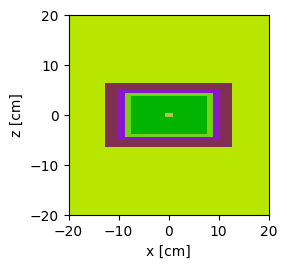

In [5]:
energy_distribution = pd.DataFrame({'strength':[1], 'energy':[1e6]})
materials, geometry, settings, tallies, source =  nns_fixed_source(4, energy_distribution=energy_distribution)
geometry.plot(origin=(0,0,0), width=(40,40), basis='xz')

# export

In [6]:
materials.export_to_xml('./xml_datafiles/materials.xml')
geometry.export_to_xml('./xml_datafiles/geometry.xml')
settings.export_to_xml('./xml_datafiles/settings.xml')
tallies.export_to_xml('./xml_datafiles/tallies.xml')

In [7]:
openmc.run(path_input='./xml_datafiles/')


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
sum = openmc.Summary('./summary.h5')

In [120]:
sum.version

(0, 14, 1)